# Hypothesis testing with `scipy` `stats`

- [Chi squared](#Chi-squared)
- [t test](#t-test)
- Binomial
    - [Distribution](#Binomial)
    - [Hypothesis test](#A-binomial-hypothesis-test)
        - [Using the critical region](#Critical-region)
        - [Using the `binom_test` function](#Alternatively)
    - [Interactive](#Using-interact)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Chi squared

In [2]:
titanic = pd.read_csv('titanic.txt', sep='\t')

The Chi square test compares the observed coincidence of two categorical variables with what the expected coincidence would be if they were independent.

Going back to the Titanic data, we can see the observed coincidence of `Sex` and `Survived` in a *contingency table* (what `pandas` calls a `crosstab`):

In [3]:
pd.crosstab(titanic.Sex, titanic.Survived, margins=True)

Survived,Alive,Dead,All
Sex,,,
Female,359,130,489
Male,353,1366,1719
All,712,1496,2208


We can pass that table to the `contingency.expected_freq` function from `scipy.stats` to see what numbers we'd expected if the two variables were independent:

In [4]:
stats.contingency.expected_freq(pd.crosstab(titanic.Sex, titanic.Survived, margins=True))


array([[ 157.68478261,  331.31521739,  489.        ],
       [ 554.31521739, 1164.68478261, 1719.        ],
       [ 712.        , 1496.        , 2208.        ]])

So it certainly looks like there's something going on. We can pass that crosstab into `chi2_contingency` to carry out the hypothesis test with:

$H_0$: The variables `Sex` and `Survived` are independent

$H_1$: There is an association between `Sex` and `Survived`

In [5]:
titanic_chi2 = stats.chi2_contingency(pd.crosstab(titanic.Sex, titanic.Survived, margins=True))
titanic_chi2

(487.2525189655862,
 3.8279207203631174e-104,
 4,
 array([[ 157.68478261,  331.31521739,  489.        ],
        [ 554.31521739, 1164.68478261, 1719.        ],
        [ 712.        , 1496.        , 2208.        ]]))

The first item is the chi square statistic, the second is the p value, and the third is the expected contingency table if the null hypothesis were true.

The high chi square statistic and very low p value strongly suggest that these two variables are *not* independent.

## t test

In [6]:
from ipywidgets import interact, IntSlider, FloatSlider

In [7]:
def update(n=30,meanA=50,stdA=1,meanB=50,stdB=1,alpha=0.05):
    # generate two sets of normally distributed data
    groupA = np.random.normal(meanA, stdA, n)
    groupB = np.random.normal(meanB, stdB, n)
    # plot them
    sns.distplot(groupA)
    sns.distplot(groupB)
    # apply an independent t-test
    ttest_result = stats.ttest_ind(groupA,groupB, equal_var=False)
    s = '''
    meanA = {}
    meanB = {}
    H0: meanA = meanB
    H1: meanA <> meanB
    t = {}
    '''  
    if (ttest_result.pvalue) <= alpha:
        s+= '''
        p = {} <= {}
        Reject H0 at the {} significance level
        '''
    else:
        s+= '''
        p = {} > {}
        Fail to reject H0 at the {} significance level
        '''
    print(s.format(groupA.mean().round(2),groupB.mean().round(2),ttest_result.statistic, ttest_result.pvalue, alpha, alpha))
interact(update,
         n=IntSlider(value=30,min=3,max=100,step=1,continuous_update=False),
         meanA=IntSlider(value=50,min=10,max=100,step=1,continuous_update=False),
         stdA=IntSlider(value=1,min=1,max=10,step=1,continuous_update=False),
         meanB=IntSlider(value=50,min=10,max=100,step=1,continuous_update=False),
         stdB=IntSlider(value=1,min=1,max=10,step=1,continuous_update=False),
         alpha=FloatSlider(value=0.05,min=0.01,max=0.1,step=0.01,continuous_update=False)
         );

interactive(children=(IntSlider(value=30, continuous_update=False, description='n', min=3), IntSlider(value=50…

## Binomial

* Use the scipy.stats [binomial](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html#scipy.stats.binom) function to generate binomial distributions. Plot them. Make an `interact` to vary the parameters
* The [binom_test](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.binom_test.html) to write a binomial hypothesis test procedure.

Generate one random number from a binomial distribution

In [8]:
stats.binom.rvs(n=100,p=1/6)

17

Recall that this represents the number of successes from $n$ independent trials, each with probability of success $p$

Let's now get a list of these to plot

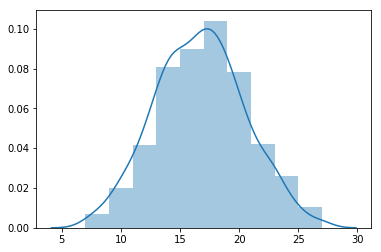

In [9]:
binomial = stats.binom.rvs(n=100,p=1/6, size=1000)
sns.distplot(binomial, bins=10);

In theory we could get from 0 to 100 success so let's fix the axes:

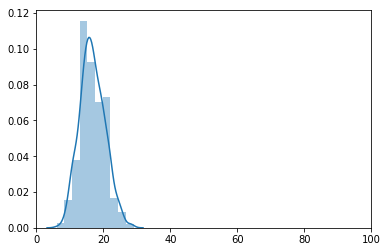

In [10]:
binomial = stats.binom.rvs(n=100,p=1/6, size=1000)
ax = sns.distplot(binomial, bins=10)
ax.set_xlim(0,100);

This shows how skewed the distribution is. We can get results over 40 successes but very rarely.

### A binomial hypothesis test
There are two ways to approach a binomial hypothesis test:

- find the probability of the observed outcome (or an even less likely outcome) and see if that is less than your chosen alpha
- identify a *critical region* of outcomes that represent your alpha and then see if the observed outcome is within that region

### Critical regions

Let's say that you think Dodgy Bob's dice is biased in favour of sixes. You're going to ask him to roll his dice a hundred times. How can we decide in advance what sort of outcome would convince us to reject the null (and safe) hypothesis and assert that the dice is biased?

Let $p$ be the probability of throwing a six on an unbiased dice.

$H_0:p=\frac{1}{6}\\H_1:p>\frac{1}{6}$

Shall we say $\alpha=0.05$ is our significance level? In other words, we'll decide the critical region by considering outcomes that have a less than 5% if the dice is *not* dodgy.

The `stats.binom.cdf(k,n,p)` function will give us the cumulative probability of getting up to and including `k` successes from `n` trials with probability `p`.

So for example the probability of getting 10 or fewer sixes from 100 rolls of an unbiased dice is:

In [11]:
stats.binom.cdf(10,100,1/6)

0.042695684147024654

So if we'd been worried about this dice being biased *against* sixes, that result would have been in our critical region!

Look how the probability of getting k or fewer successes increases as k goes from 0 to 100:

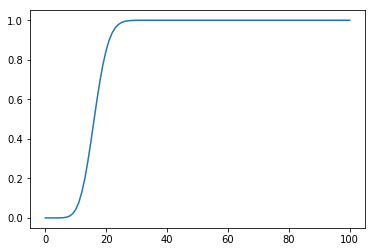

In [12]:
ks = np.arange(101)
bcdf = [stats.binom.cdf(k,100,1/6) for k in ks]
sns.lineplot(ks, bcdf);

To identify our critical region, we need to know when k crosses into the 95% region. In other words, there's a 95% chance that we get fewer than k successes, or a 5% chance that we get k or more.

`stats.binom` has a function for that too:

In [13]:
stats.binom.ppf(0.95,100,1/6)

23.0

The critical region starts at 23 then:

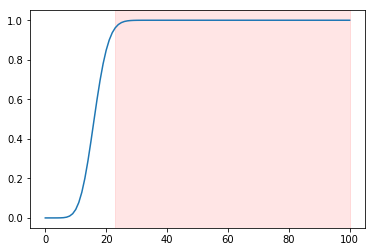

In [14]:
ks = np.arange(101)
bcdf = [stats.binom.cdf(k,100,1/6) for k in ks]
ax = sns.lineplot(ks, bcdf)
ax.axvspan(23,100,color="red",alpha=0.1);

Just to check:

In [15]:
stats.binom.cdf(23,100,1/6)

0.9621356313465913

So 23 sixes is in our critical region.

Now we can get Dodgy Bob to roll the dice 100 times and if he rolls 23 or more sixes we can reject the null hypothesis at the 5% significance level.

We could then repeat this with as many suspected dodgy dice owners as we like. But note that for every twenty accusations we make, we'd expect one of them to be a false accusation! 

### Alternatively

Alternatively, suppose we've already seen Dodgy Bob roll his dice 100 times, and he just got 25 sixes. We can carry out the hypothesis test in one line like this:

In [16]:
stats.binom_test(25, 100, 1/6)

0.031235750326025068

This p value is less than our threshold, so we reject the null hypothesis as before.

If he'd rolled 21 sixes:

In [17]:
stats.binom_test(21, 100, 1/6)

0.22960706910147133

This is perhaps an unusually high number of sixes, but the p value is not below our threshold, so we fail to reject the null hypothesis, and leave Dodgy Bob with his dice.

### Using interact

In [18]:
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown

In [19]:

def update(n,p,alpha,tails):
    ks = np.arange(n+1)
    bcdf = [stats.binom.cdf(k,n,p) for k in ks]
    ax = sns.lineplot(ks, bcdf)
    if tails == "both":
        a = alpha/2
    else:
        a = alpha
    if tails == "both" or tails == "left":
        left_crit = int(stats.binom.ppf(a,n,p))
        ax.axvspan(0,left_crit,color="red",alpha=0.1)
        ax.annotate(left_crit,(left_crit,0.5))
    if tails == "both" or tails == "right":
        right_crit = int(stats.binom.ppf(1-a,n,p))
        ax.axvspan(right_crit,n,color="red",alpha=0.1)
        ax.annotate(right_crit,(right_crit,0.5))
        # The alpha here is opacity not significance level!

interact(update,
        n = IntSlider(value=100, min=10, max=200, continuous_update=False),
        p = FloatSlider(value=1/6, min=0.01, max=0.99, continuous_update=False),
        alpha = Dropdown(options=[0.05,0.01,0.005,0.001]),
        tails = Dropdown(options=["left","right","both"]));

interactive(children=(IntSlider(value=100, continuous_update=False, description='n', max=200, min=10), FloatSl…